In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings

from util import silhouette_plot, cluster_stability
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")

In [2]:
df_main = pd.read_csv("zip_code_age_lg_wealth_osm_percentage.csv", index_col="Unnamed: 0")
df_main = df_main.drop(index=10020)  # missing all the data
print(f'shape: {df_main.shape}')
df_main.head(2)

shape: (62, 27)


,female[0-9],male[0-9],female[10-19],male[10-19],female[20-29],male[20-29],female[30-39],male[30-39],female[40-49],male[40-49],...,"50,000-75,000","75,000-100,000","100,000-200,000","200,000-...",stadium_count,shoes_count,restaurant_count,gym_count,clothes_count,clinic_count
10026,0.059201,0.056966,0.058436,0.059289,0.094345,0.08111,0.092021,0.078905,0.083287,0.079199,...,0.136957,0.078261,0.100000,0.053261,0.0,0.0,18.0,0.0,0.0,1.0
10027,0.050966,0.050011,0.077194,0.067228,0.131140,0.10853,0.077478,0.069054,0.066776,0.061601,...,0.126863,0.064340,0.086514,0.046529,0.0,2.0,25.0,4.0,5.0,1.0


In [3]:
for osm in ['stadium', 'shoes', 'restaurant', 'gym', 'clothes', 'clinic']:
    col_name = f'{osm}_count'
    sparsity = np.sum(df_main[col_name]==0) / df_main.shape[0]
    print(f'{osm} sparsity: {sparsity}')

stadium sparsity: 0.9193548387096774
shoes sparsity: 0.43548387096774194
restaurant sparsity: 0.04838709677419355
gym sparsity: 0.5
clothes sparsity: 0.3870967741935484
clinic sparsity: 0.43548387096774194


In [4]:
mask = df_main.columns[df_main.columns!='stadium_count']
df_main = df_main[mask]
df_main.shape

(62, 26)

## Design a Model

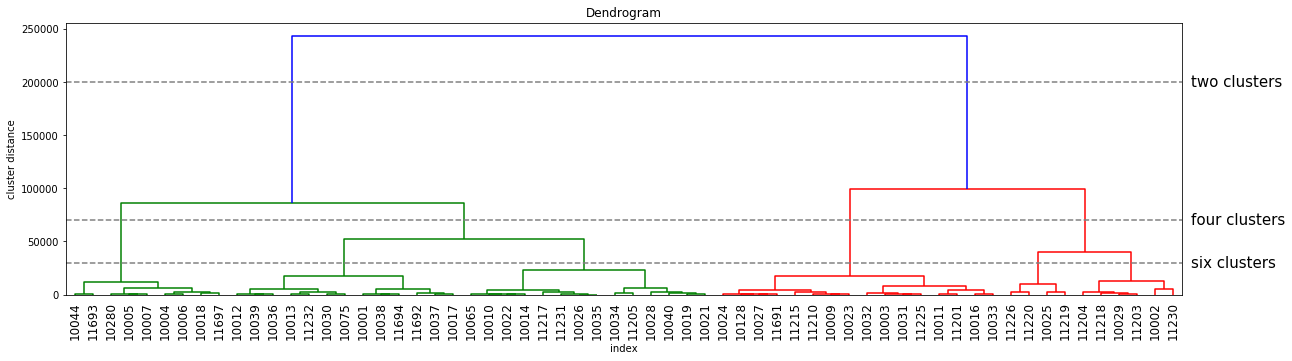

In [5]:
plt.figure(figsize=(20, 5))
linkage_array = ward(df_main)
dendrogram(linkage_array, leaf_font_size=12)

h_line = [200000, 70000, 30000]

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [h_line[0], h_line[0]], '--', c='grey')
ax.plot(bounds, [h_line[1], h_line[1]], '--', c='grey')
ax.plot(bounds, [h_line[2], h_line[2]], '--', c='grey')

ax.text(bounds[1]+5, h_line[0], 'two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1]+5, h_line[1], 'four clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1]+5, h_line[2], 'six clusters', va='center', fontdict={'size': 15})

ax.set_xlabel("index")
ax.set_ylabel("cluster distance")
ax.set_xticklabels([df_main.index[int(i.get_text())] for i in ax.get_xticklabels()])
ax.set_title("Dendrogram")
plt.show()

In [9]:
params = {"kmeans__n_clusters": [2, 3, 4, 5, 6]}
pipe = make_pipeline(StandardScaler(), KMeans(init='random'))
kmeans = GridSearchCV(pipe, param_grid=params, cv=10)
for epoch in range(20):
    kmeans.fit(df_main)
    print(f'epoch {epoch}: {kmeans.best_params_}', end="\t")
    if (epoch%3)==2: print("") 

epoch 0: {'kmeans__n_clusters': 6}	epoch 1: {'kmeans__n_clusters': 6}	epoch 2: {'kmeans__n_clusters': 6}	
epoch 3: {'kmeans__n_clusters': 6}	epoch 4: {'kmeans__n_clusters': 5}	epoch 5: {'kmeans__n_clusters': 6}	
epoch 6: {'kmeans__n_clusters': 6}	epoch 7: {'kmeans__n_clusters': 5}	epoch 8: {'kmeans__n_clusters': 4}	
epoch 9: {'kmeans__n_clusters': 6}	epoch 10: {'kmeans__n_clusters': 6}	epoch 11: {'kmeans__n_clusters': 6}	
epoch 12: {'kmeans__n_clusters': 6}	epoch 13: {'kmeans__n_clusters': 6}	epoch 14: {'kmeans__n_clusters': 5}	
epoch 15: {'kmeans__n_clusters': 4}	epoch 16: {'kmeans__n_clusters': 4}	epoch 17: {'kmeans__n_clusters': 5}	
epoch 18: {'kmeans__n_clusters': 6}	epoch 19: {'kmeans__n_clusters': 5}	

In [12]:
df_main_scaled = StandardScaler().fit_transform(df_main)

In [54]:
_, stab6 = cluster_stability(df_main_scaled, KMeans(init='random', n_clusters=6), n_iter=10)
km6 = KMeans(init='random', n_clusters=6).fit(df_main_scaled)
print("silhouette: %.4f" % silhouette_score(df_main_scaled, km6.labels_), end=" ")
print(f"stability: {stab6}")

silhouette: 0.2341 stability: 0.5691484062851471


In [55]:
_, stab5 = cluster_stability(df_main_scaled, KMeans(init='random', n_clusters=5), n_iter=10)
km5 = KMeans(init='random', n_clusters=5).fit(df_main_scaled)
print("silhouette: %.4f" % silhouette_score(df_main_scaled, km5.labels_), end=" ")
print(f"stability: {stab5}")

silhouette: 0.2136 stability: 0.62052146528129


In [56]:
_, stab4 = cluster_stability(df_main_scaled, KMeans(init='random', n_clusters=4), n_iter=10)
km4 = KMeans(init='random', n_clusters=4).fit(df_main_scaled)
print("silhouette: %.4f" % silhouette_score(df_main_scaled, km4.labels_), end=" ")
print(f"stability: {stab4}")

silhouette: 0.2665 stability: 0.7126715605010978


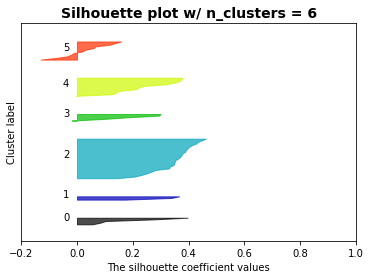

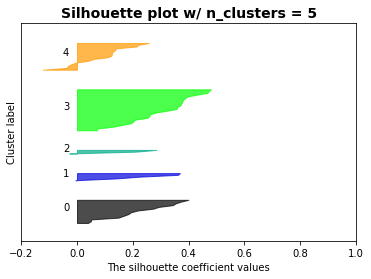

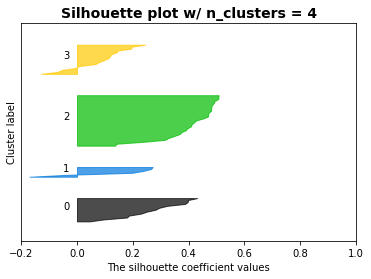

In [57]:
silhouette_plot(df_main_scaled, km6.labels_, 6)
silhouette_plot(df_main_scaled, km5.labels_, 5)
silhouette_plot(df_main_scaled, km4.labels_, 4)

In [58]:
params = {"n_clusters": [2, 3, 4, 5, 6]}

for nc in params["n_clusters"]:
    _, stability_score = cluster_stability(df_main_scaled, AgglomerativeClustering(n_clusters=nc), n_iter=10)
    model = AgglomerativeClustering(n_clusters=nc)
    model.fit(df_main_scaled)
    print("# Clusters: %d | Stability: %.4f | Silhouette: %.4f" % (nc, stability_score, silhouette_score(df_main_scaled, model.labels_)))

# Clusters: 2 | Stability: 0.8421 | Silhouette: 0.2940
# Clusters: 3 | Stability: 0.7595 | Silhouette: 0.3021
# Clusters: 4 | Stability: 0.6645 | Silhouette: 0.2633
# Clusters: 5 | Stability: 0.6327 | Silhouette: 0.2917
# Clusters: 6 | Stability: 0.6721 | Silhouette: 0.2752


In [69]:
tsne_embedded = TSNE(n_components=2).fit_transform(df_main_scaled)

In [75]:
agg3 = AgglomerativeClustering(n_clusters=3).fit(df_main_scaled)
agg5 = AgglomerativeClustering(n_clusters=5).fit(df_main_scaled)

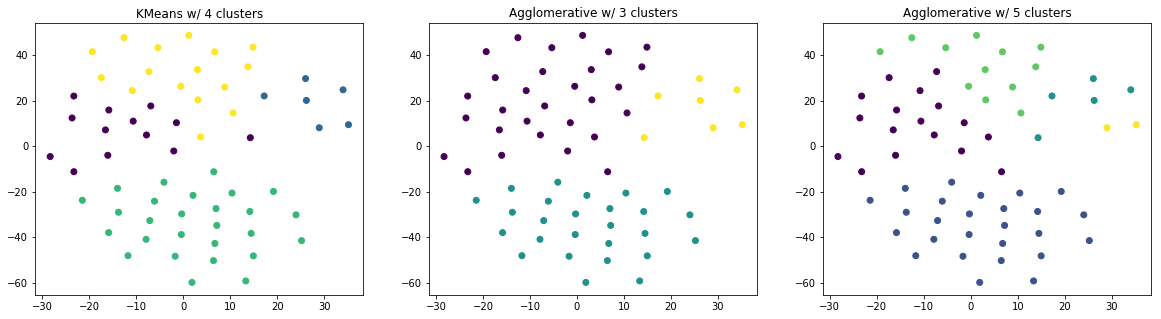

In [79]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], c=km4.labels_)
plt.title("KMeans w/ 4 clusters")

plt.subplot(1,3,2)
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], c=agg3.labels_)
plt.title("Agglomerative w/ 3 clusters")

plt.subplot(1,3,3)
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], c=agg5.labels_)
plt.title("Agglomerative w/ 5 clusters")

plt.show()

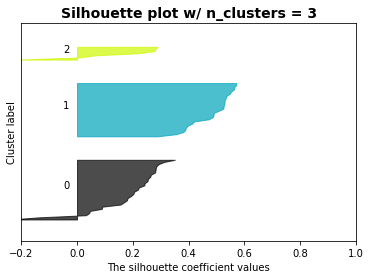

In [80]:
silhouette_plot(df_main_scaled, agg3.labels_, 3)

In [120]:
for min_samples in [2, 3, 4]:
    for eps in np.logspace(-2, 4, 40):
        db = DBSCAN(eps=eps, min_samples=min_samples)
        clustered_data = db.fit_predict(df_main_scaled)
        
        y_predict = np.unique(clustered_data)
        n_clusters = len(y_predict)
        if n_clusters > 3 or (n_clusters >= 2 and -1 not in y_predict):
            print("Min Samples:", min_samples)
            print("Eps:", eps)
            print("Silhouette:", silhouette_score(df_main_scaled, clustered_data))
            print(y_predict, "\n")

Min Samples: 2
Eps: 2.030917620904737
Silhouette: -0.06914258514582754
[-1  0  1  2  3] 

Min Samples: 2
Eps: 2.8942661247167516
Silhouette: 0.10838540764888296
[-1  0  1  2  3] 

Min Samples: 2
Eps: 4.1246263829013525
Silhouette: 0.1526370563945117
[-1  0  1  2  3] 

Min Samples: 2
Eps: 5.878016072274912
Silhouette: 0.4091516247320563
[0 1] 

